In [74]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set the seaborn style for better Jupyter display
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

In [75]:
# Assuming 'ecom' DataFrame is already loaded and preprocessed with columns renamed
# If not, uncomment these lines:
ecom = pd.read_csv('superstore.csv', encoding='latin-1')

ecom.columns = ecom.columns.str.lower().str.replace(' ', '_', regex=True)
ecom['order_date'] = pd.to_datetime(ecom['order_date'])
ecom['ship_date'] = pd.to_datetime(ecom['ship_date'])


In [76]:
# Calculate metrics needed for CLV analysis
# Step 1: Calculate profit margin and organize data by product & customer
ecom['profit_margin'] = ecom['profit'] / ecom['sales']

# Group by product and customer
product_customer = ecom.groupby(['product_id', 'customer_id']).agg({
    'sales': 'sum',
    'profit': 'sum',
    'order_id': 'nunique',
    'order_date': 'max'
}).reset_index()

product_customer['profit_margin'] = product_customer['profit'] / product_customer['sales']


In [77]:
# Step 2: Calculate product-level metrics
product_clv = product_customer.groupby('product_id').agg({
    'sales': 'mean',
    'profit_margin': 'mean',
    'order_id': 'mean',
    'customer_id': 'nunique'
}).reset_index()

product_clv['traditional_clv'] = product_clv['sales'] * product_clv['order_id']
product_clv['profit_adjusted_clv'] = product_clv['traditional_clv'] * product_clv['profit_margin']


In [78]:
discount_sensitivity = []
for product in ecom['product_id'].unique():
    product_data = ecom[ecom['product_id'] == product]
    # Check if there's enough variation in both discount and quantity
    if product_data.shape[0] > 1 and product_data['discount'].std() > 0 and product_data['quantity'].std() > 0:
        correlation = product_data['discount'].corr(product_data['quantity'])
        discount_sensitivity.append({
            'product_id': product,
            'discount_sensitivity': correlation
        })
    else:
        # Handle cases with no variation
        discount_sensitivity.append({
            'product_id': product,
            'discount_sensitivity': 0  # or np.nan if you prefer
        })

In [79]:
# Step 4: Combine all metrics
discount_data = pd.merge(discount_df, avg_discount, on='product_id', how='left')
discount_clv = pd.merge(discount_data, 
                        product_clv[['product_id', 'traditional_clv']], 
                        on='product_id', how='left')
discount_clv['discount_adjusted_clv'] = discount_clv['traditional_clv'] * \
                                       (1 - (discount_clv['discount_sensitivity'] * discount_clv['avg_discount']))

# Combine all data
combined_clv = pd.merge(
    product_clv[['product_id', 'traditional_clv', 'profit_adjusted_clv', 'profit_margin']], 
    discount_clv[['product_id', 'discount_adjusted_clv', 'discount_sensitivity', 'avg_discount']],
    on='product_id', how='left'
)

# Add product info
product_info = ecom[['product_id', 'product_name', 'category', 'sub-category']].drop_duplicates()
combined_clv = pd.merge(combined_clv, product_info, on='product_id', how='left')
combined_clv['composite_clv'] = combined_clv['profit_adjusted_clv'] * \
                              (1 - (combined_clv['discount_sensitivity'] * combined_clv['avg_discount']))


KeyError: 'product_id'

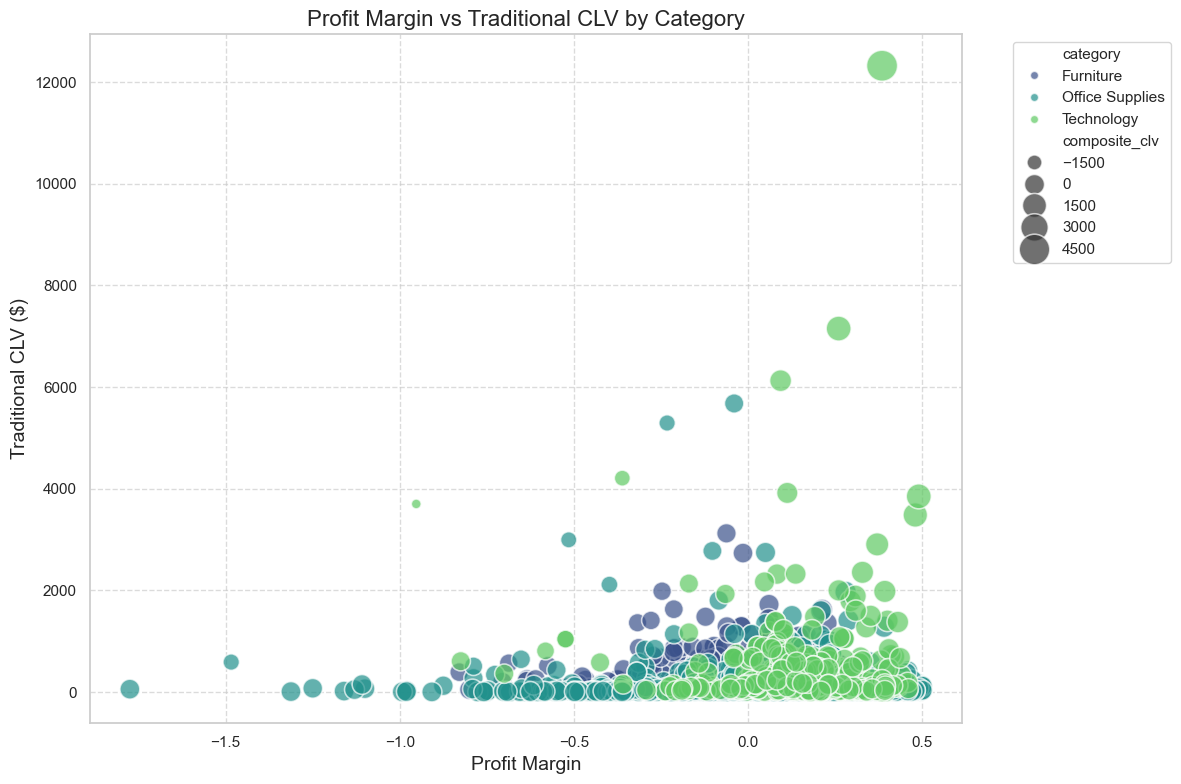

In [ ]:
# Create visualizations

# 1. Profit Margin vs CLV by Category (with improved styling for Jupyter)
plt.figure(figsize=(12, 8))
scatter = sns.scatterplot(
    x='profit_margin', 
    y='traditional_clv',
    hue='category',
    size='composite_clv',
    sizes=(50, 500),
    alpha=0.7,
    palette='viridis',
    data=combined_clv
)

# Format for better Jupyter display
scatter.set_title('Profit Margin vs Traditional CLV by Category', fontsize=16)
scatter.set_xlabel('Profit Margin', fontsize=14)
scatter.set_ylabel('Traditional CLV ($)', fontsize=14)
scatter.grid(True, linestyle='--', alpha=0.7)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()  # Explicitly show the plot in Jupyter


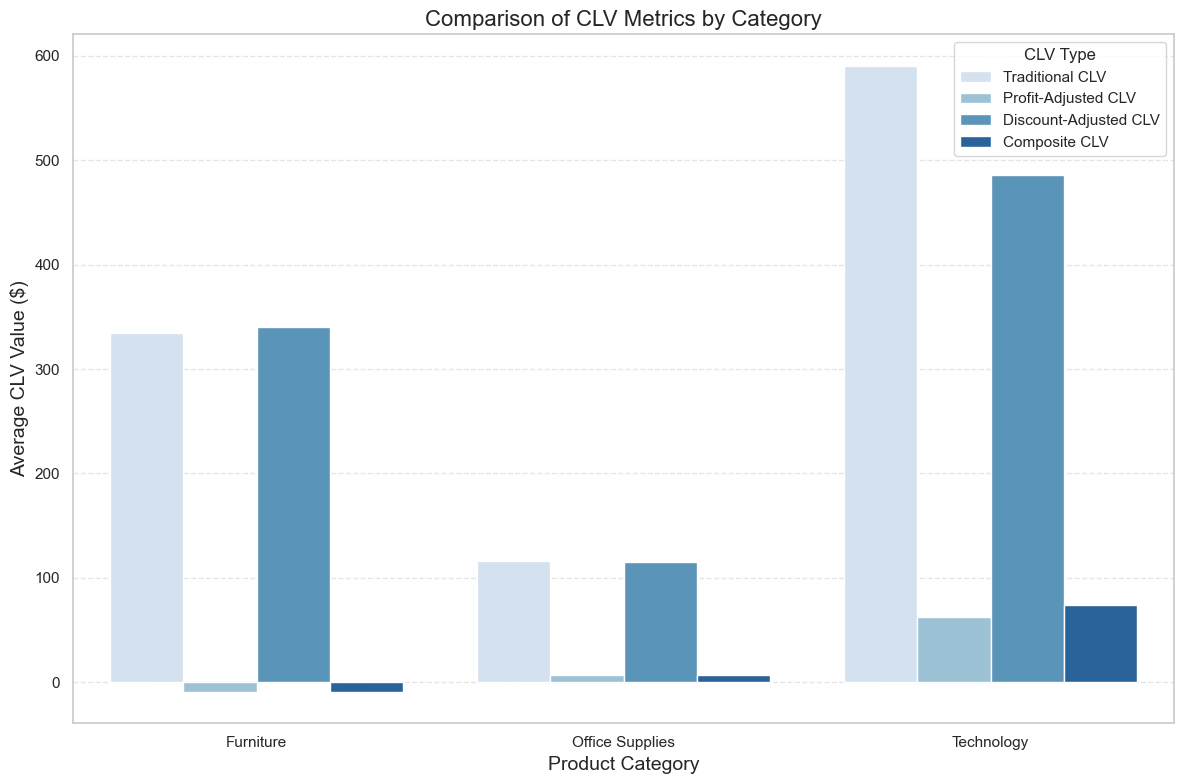

In [ ]:
# 2. Category Comparison - Bar Plot with confidence intervals
plt.figure(figsize=(12, 8))
category_clv = combined_clv.groupby('category').agg({
    'traditional_clv': 'mean',
    'profit_adjusted_clv': 'mean',
    'discount_adjusted_clv': 'mean',
    'composite_clv': 'mean'
}).reset_index()

category_melted = pd.melt(
    category_clv, 
    id_vars=['category'],
    value_vars=['traditional_clv', 'profit_adjusted_clv', 'discount_adjusted_clv', 'composite_clv'],
    var_name='clv_type', 
    value_name='value'
)

# Map variable names to more readable labels
category_melted['clv_type'] = category_melted['clv_type'].map({
    'traditional_clv': 'Traditional CLV',
    'profit_adjusted_clv': 'Profit-Adjusted CLV',
    'discount_adjusted_clv': 'Discount-Adjusted CLV',
    'composite_clv': 'Composite CLV'
})

bar = sns.barplot(
    x='category', 
    y='value', 
    hue='clv_type', 
    data=category_melted,
    palette='Blues'
)

bar.set_title('Comparison of CLV Metrics by Category', fontsize=16)
bar.set_xlabel('Product Category', fontsize=14)
bar.set_ylabel('Average CLV Value ($)', fontsize=14)
bar.tick_params(axis='x', rotation=0)
plt.legend(title='CLV Type')
plt.grid(True, linestyle='--', alpha=0.5, axis='y')
plt.tight_layout()
plt.show()


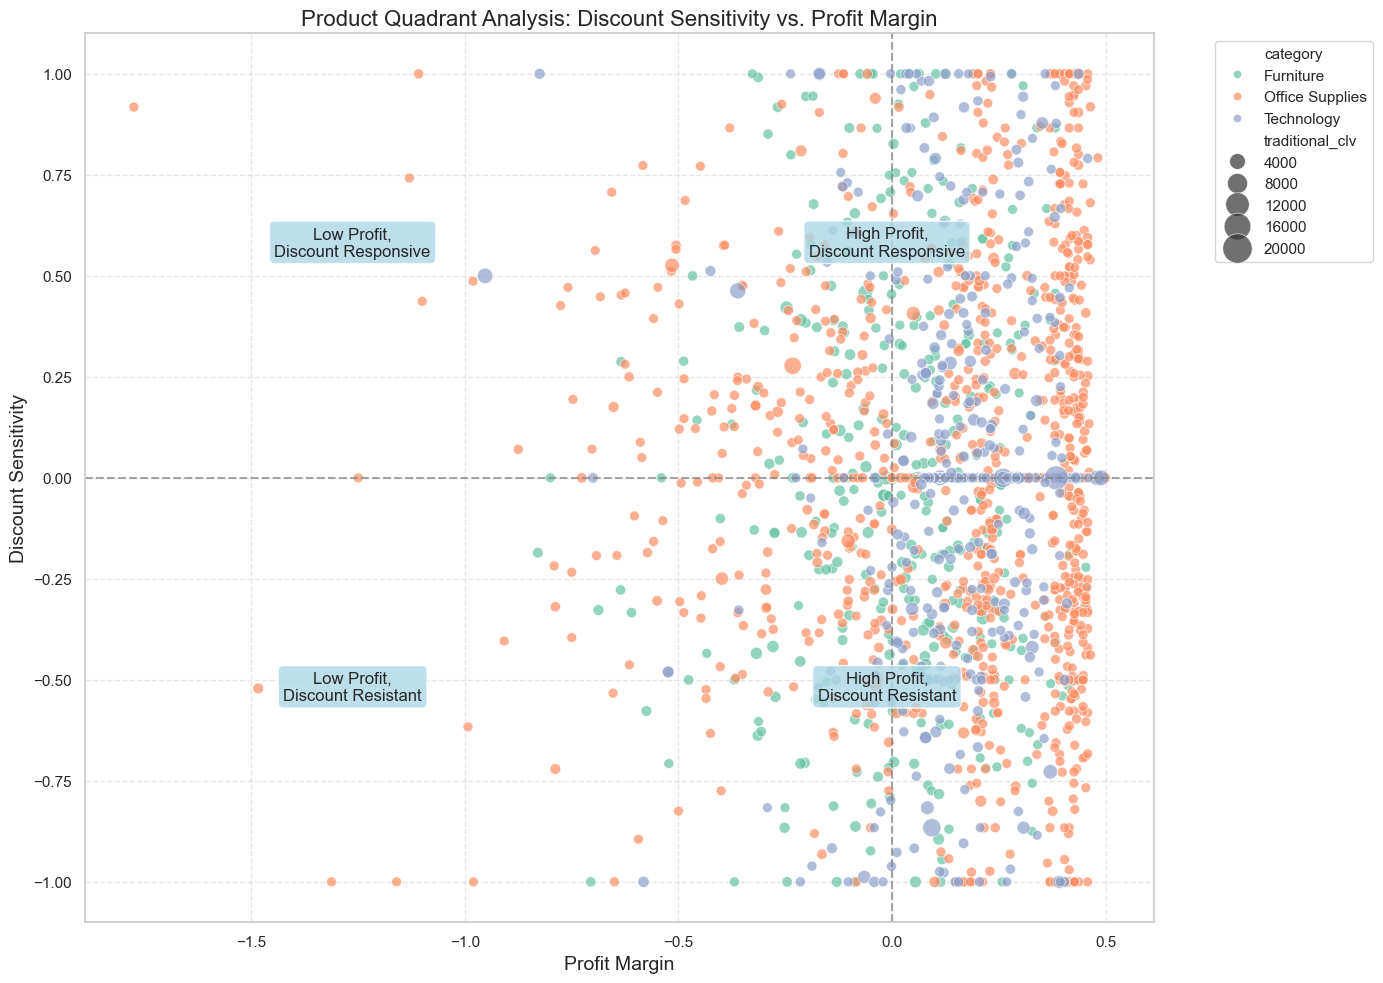

In [ ]:
# 3. Quadrant Analysis - Discount Sensitivity vs. Profit Margin
plt.figure(figsize=(14, 10))
quadrant = sns.scatterplot(
    x='profit_margin',
    y='discount_sensitivity',
    hue='category',
    size='traditional_clv',
    sizes=(50, 500),
    alpha=0.7,
    palette='Set2',
    data=combined_clv
)

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Add quadrant labels with better styling
plt.annotate('High Profit,\nDiscount Responsive', xy=(0.75, 0.75), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Responsive', xy=(0.25, 0.75), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('High Profit,\nDiscount Resistant', xy=(0.75, 0.25), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Resistant', xy=(0.25, 0.25), xycoords='axes fraction',
            bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)

quadrant.set_title('Product Quadrant Analysis: Discount Sensitivity vs. Profit Margin', fontsize=16)
quadrant.set_xlabel('Profit Margin', fontsize=14)
quadrant.set_ylabel('Discount Sensitivity', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


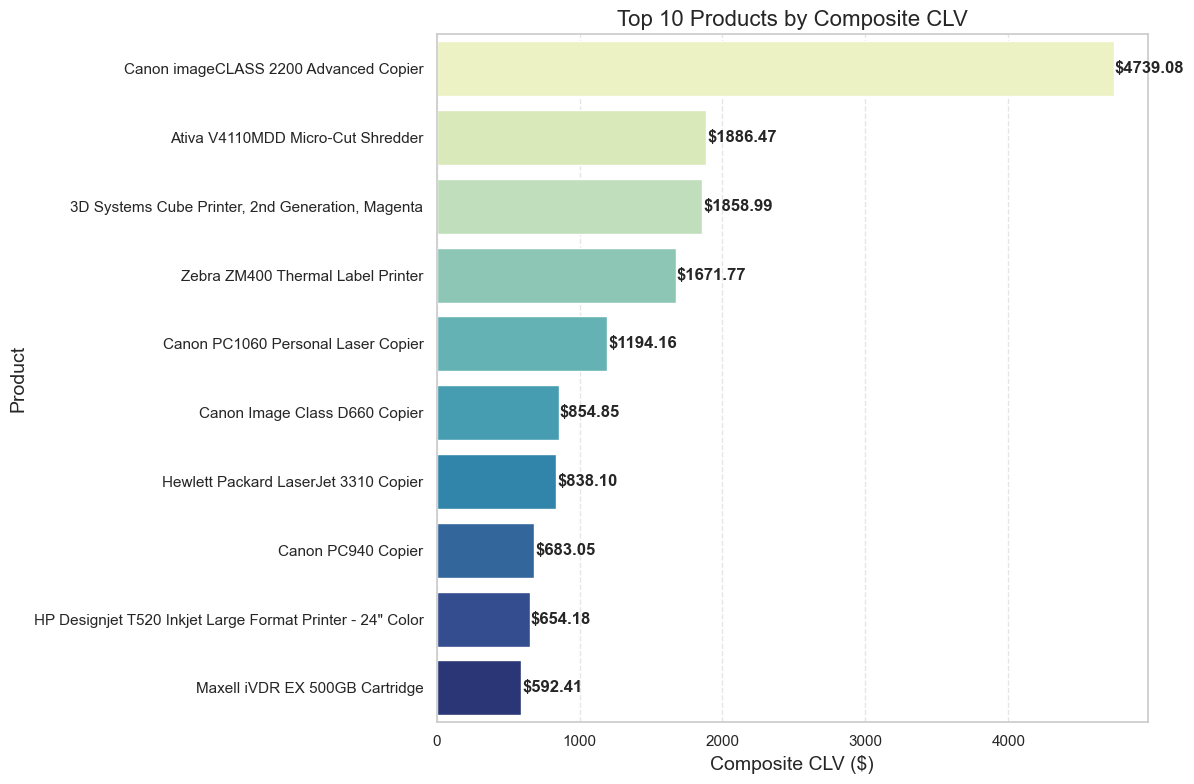

In [ ]:
# 4. Top 10 Products by Composite CLV
top10 = combined_clv.sort_values('composite_clv', ascending=False).head(10)
plt.figure(figsize=(12, 8))

# Create horizontal bar chart with updated styling to fix the warning
top10_plot = sns.barplot(
    y='product_name',
    x='composite_clv',
    hue='product_name',  # Add this line to address the warning
    data=top10,
    palette='YlGnBu',
    orient='h',
    legend=False  # Hide the legend since we don't need it
)

# Add value labels to the end of each bar
for i, v in enumerate(top10['composite_clv']):
    top10_plot.text(v + 5, i, f'${v:.2f}', va='center', fontweight='bold')

top10_plot.set_title('Top 10 Products by Composite CLV', fontsize=16)
top10_plot.set_xlabel('Composite CLV ($)', fontsize=14)
top10_plot.set_ylabel('Product', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.5, axis='x')
plt.tight_layout()
plt.show()

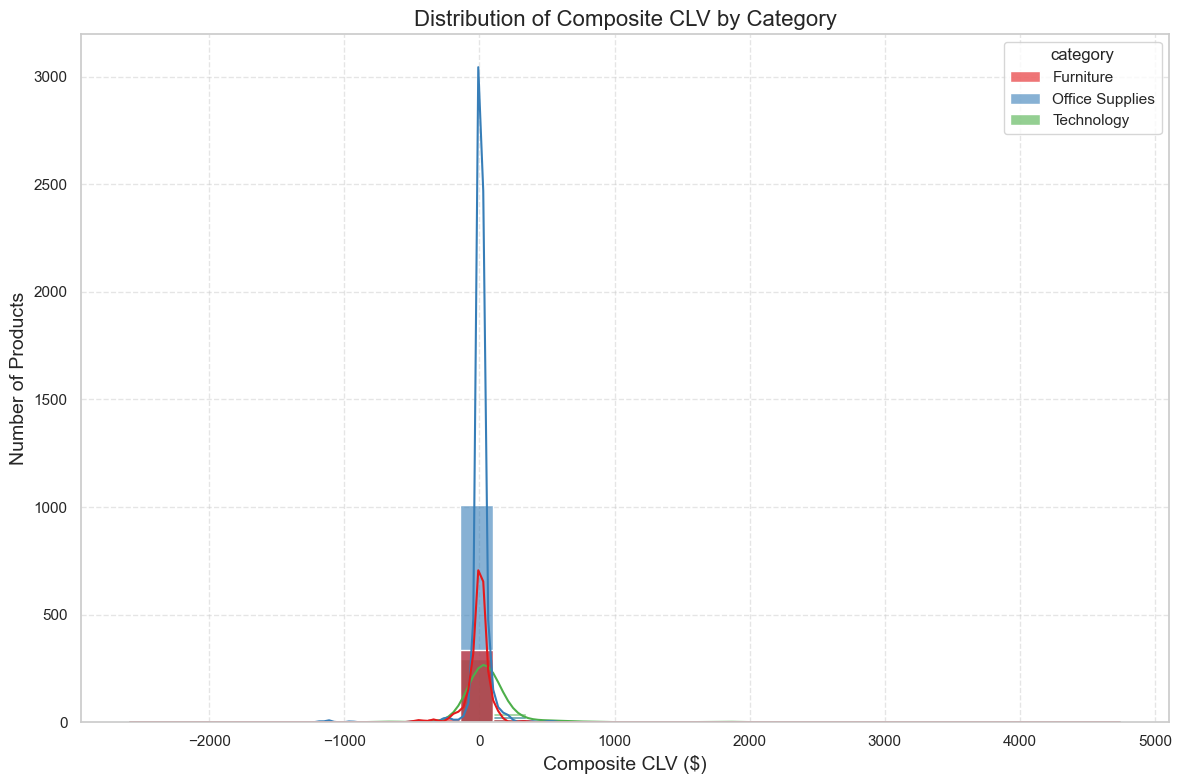

In [ ]:
# 5. Distribution of CLV Values with KDE
plt.figure(figsize=(12, 8))
dist = sns.histplot(
    data=combined_clv,
    x='composite_clv',
    hue='category',
    kde=True,
    bins=30,
    alpha=0.6,
    palette='Set1'
)

dist.set_title('Distribution of Composite CLV by Category', fontsize=16)
dist.set_xlabel('Composite CLV ($)', fontsize=14)
dist.set_ylabel('Number of Products', fontsize=14)

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [ ]:
# SUBCATEGORY ANALYSIS
# Group data by subcategory and customer
subcategory_customer = ecom.groupby(['sub-category', 'customer_id']).agg({
    'sales': 'sum',
    'profit': 'sum',
    'order_id': 'nunique',
    'discount': 'mean'
}).reset_index()

# Calculate profit margin
subcategory_customer['profit_margin'] = subcategory_customer['profit'] / subcategory_customer['sales']

# Calculate metrics by subcategory
subcategory_metrics = subcategory_customer.groupby('sub-category').agg({
    'customer_id': 'nunique',  # Number of customers
    'sales': 'mean',           # Average sales per customer
    'profit': 'mean',          # Average profit per customer
    'profit_margin': 'mean',   # Average profit margin
    'order_id': 'mean',        # Average orders per customer
    'discount': 'mean'         # Average discount
}).reset_index()

# Calculate traditional CLV
subcategory_metrics['traditional_clv'] = subcategory_metrics['sales'] * subcategory_metrics['order_id']

# Calculate profit-adjusted CLV
subcategory_metrics['profit_adjusted_clv'] = subcategory_metrics['traditional_clv'] * subcategory_metrics['profit_margin']

# Calculate discount sensitivity
discount_sensitivity = []
for subcat in ecom['sub-category'].unique():
    subcat_data = ecom[ecom['sub-category'] == subcat]
    if subcat_data.shape[0] > 1:
        correlation = subcat_data['discount'].corr(subcat_data['quantity'])
        discount_sensitivity.append({
            'sub-category': subcat,
            'discount_sensitivity': correlation if not np.isnan(correlation) else 0
        })

discount_df = pd.DataFrame(discount_sensitivity)
subcategory_metrics = pd.merge(subcategory_metrics, discount_df, on='sub-category', how='left')

# Add category information
category_info = ecom[['sub-category', 'category']].drop_duplicates()
subcategory_metrics = pd.merge(subcategory_metrics, category_info, on='sub-category', how='left')

# Calculate composite CLV
subcategory_metrics['composite_clv'] = subcategory_metrics['profit_adjusted_clv'] * \
                                     (1 - (subcategory_metrics['discount_sensitivity'] * subcategory_metrics['discount']))

In [ ]:
# State analysis 
# Group data by state and customer
state_customer = ecom.groupby(['state', 'customer_id']).agg({
    'sales': 'sum',
    'profit': 'sum',
    'order_id': 'nunique',
    'discount': 'mean'
}).reset_index()

# Calculate profit margin with error handling
state_customer['profit_margin'] = np.where(
    state_customer['sales'] > 0,
    state_customer['profit'] / state_customer['sales'],
    0  # Default value when sales is 0
)

# Calculate metrics by state
state_metrics = state_customer.groupby('state').agg({
    'customer_id': 'nunique',  # Number of customers
    'sales': 'mean',           # Average sales per customer
    'profit': 'mean',          # Average profit per customer
    'profit_margin': 'mean',   # Average profit margin
    'order_id': 'mean',        # Average orders per customer
    'discount': 'mean'         # Average discount
}).reset_index()

# Calculate traditional CLV
state_metrics['traditional_clv'] = state_metrics['sales'] * state_metrics['order_id']

# Calculate profit-adjusted CLV
state_metrics['profit_adjusted_clv'] = state_metrics['traditional_clv'] * state_metrics['profit_margin']

# Calculate discount sensitivity - improved version
state_discount_sensitivity = []
for state in ecom['state'].unique():
    state_data = ecom[ecom['state'] == state]
    # Only calculate correlation if we have enough data points and valid values
    if state_data.shape[0] > 10:  # Increased minimum sample size for more reliable correlation
        # Filter out any NaN values
        valid_data = state_data.dropna(subset=['discount', 'quantity'])
        # Check if there's variation in the data (to avoid division by zero)
        if valid_data['discount'].std() > 0 and valid_data['quantity'].std() > 0:
            correlation = valid_data['discount'].corr(valid_data['quantity'])
            state_discount_sensitivity.append({
                'state': state,
                'discount_sensitivity': correlation
            })
        else:
            # If no variation, set correlation to 0
            state_discount_sensitivity.append({
                'state': state,
                'discount_sensitivity': 0
            })
    else:
        # Not enough data points
        state_discount_sensitivity.append({
            'state': state,
            'discount_sensitivity': 0
        })

# Convert to DataFrame
state_discount_df = pd.DataFrame(state_discount_sensitivity)

# Merge with state metrics
state_metrics = pd.merge(state_metrics, state_discount_df, on='state', how='left')

# Calculate composite CLV with NaN handling
state_metrics['composite_clv'] = state_metrics['profit_adjusted_clv'] * \
                               (1 - (state_metrics['discount_sensitivity'].fillna(0) * state_metrics['discount']))

# Add region information
region_info = ecom[['state', 'region']].drop_duplicates()
state_metrics = pd.merge(state_metrics, region_info, on='state', how='left')

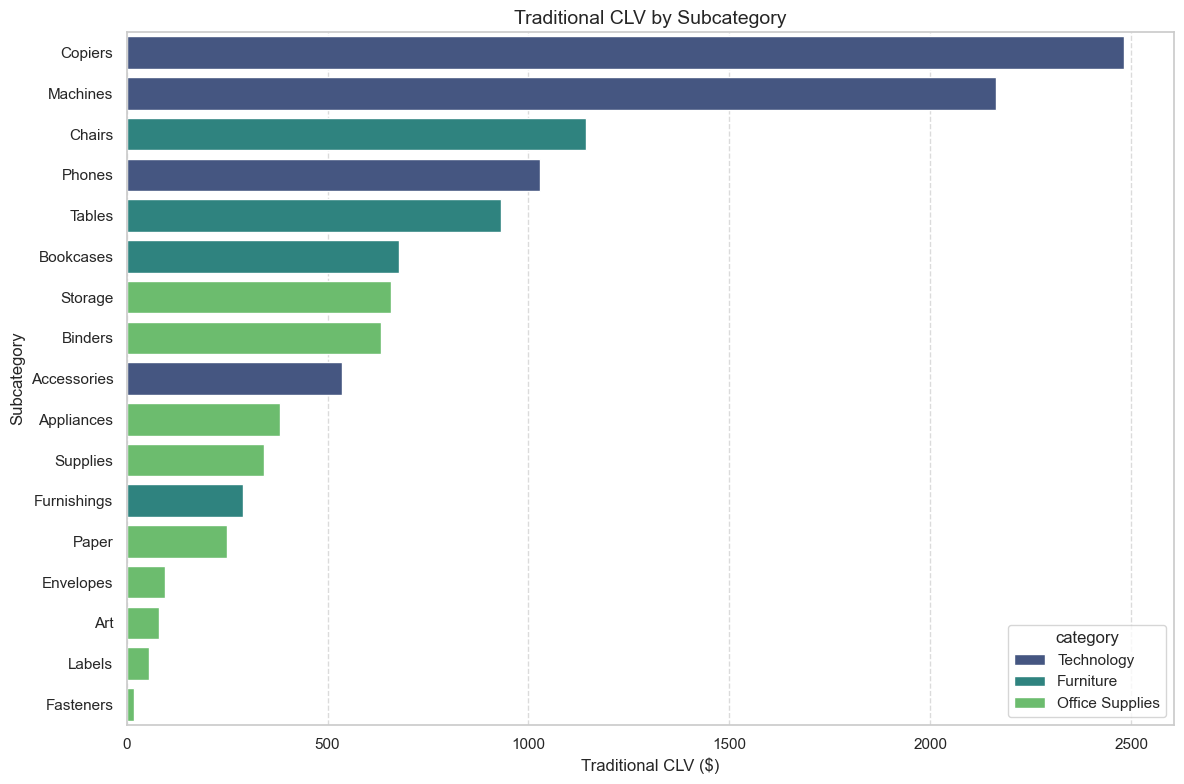

In [ ]:
# 1. Subcategory CLV comparison
plt.figure(figsize=(12, 8))
sns.barplot(
        x='traditional_clv', 
        y='sub-category',
        hue='category',
        data=subcategory_metrics.sort_values('traditional_clv', ascending=False),
        palette='viridis'
    )
plt.title('Traditional CLV by Subcategory', fontsize=14)
plt.xlabel('Traditional CLV ($)', fontsize=12)
plt.ylabel('Subcategory', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7, axis='x')
plt.tight_layout()
plt.show()  # This displays the plot directly in VS Code


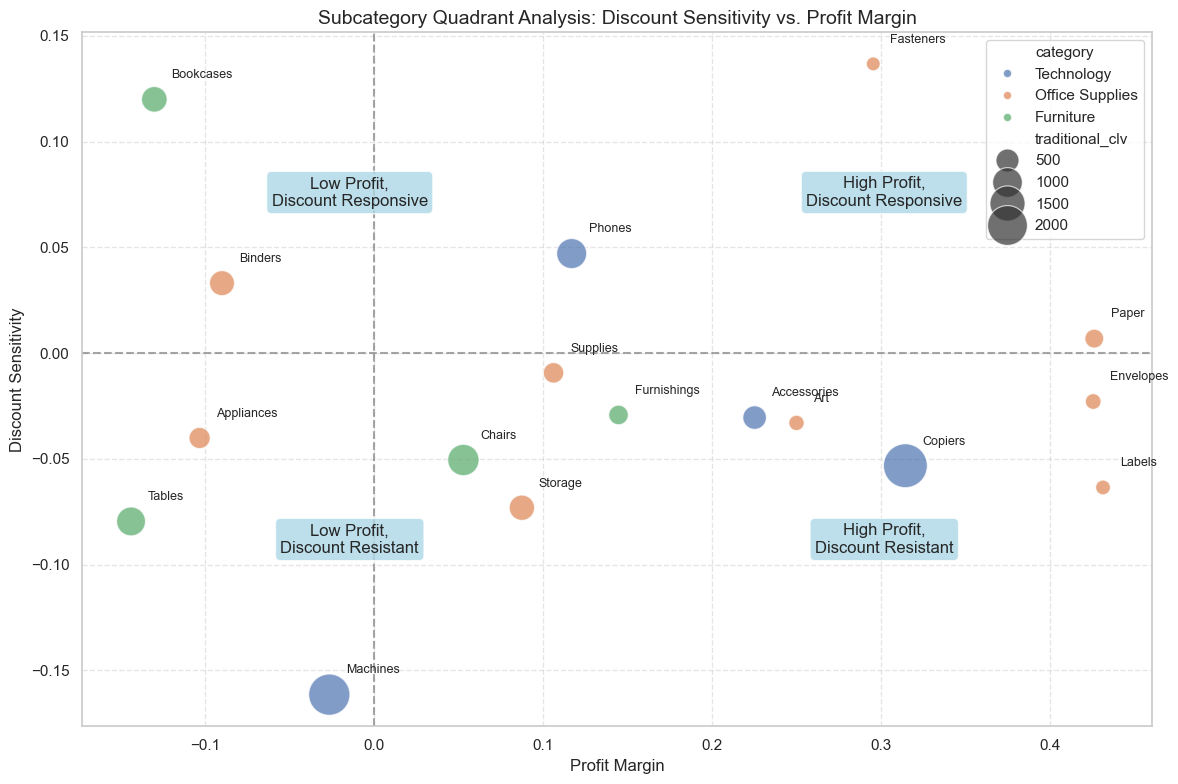

In [ ]:
# 2. Subcategory Quadrant Analysis
plt.figure(figsize=(12, 8))
sns.scatterplot(
        x='profit_margin',
        y='discount_sensitivity',
        size='traditional_clv',
        hue='category',
        sizes=(100, 1000),
        alpha=0.7,
        data=subcategory_metrics
    )

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Add labels for each subcategory
for i, row in subcategory_metrics.iterrows():
        plt.text(row['profit_margin'] + 0.01, 
                row['discount_sensitivity'] + 0.01, 
                row['sub-category'], 
                fontsize=9)

# Add quadrant labels
plt.annotate('High Profit,\nDiscount Responsive', xy=(0.75, 0.75), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Responsive', xy=(0.25, 0.75), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('High Profit,\nDiscount Resistant', xy=(0.75, 0.25), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Resistant', xy=(0.25, 0.25), xycoords='axes fraction',
                bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)

plt.title('Subcategory Quadrant Analysis: Discount Sensitivity vs. Profit Margin', fontsize=14)
plt.xlabel('Profit Margin', fontsize=12)
plt.ylabel('Discount Sensitivity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()  # This displays the plot directly in VS Code


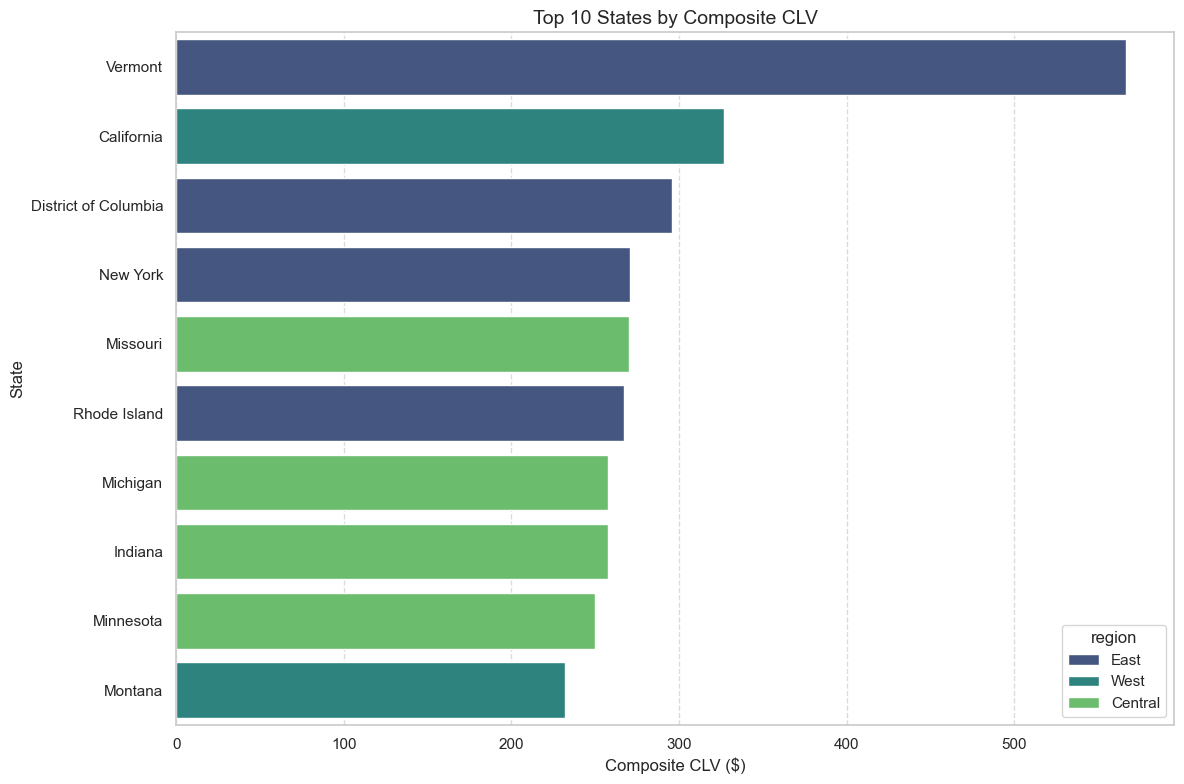

In [ ]:
# 3. Top 10 States by CLV
plt.figure(figsize=(12, 8))
top_states = state_metrics.sort_values('composite_clv', ascending=False).head(10)
sns.barplot(
        x='composite_clv',
        y='state',
        hue='region',
        data=top_states,
        palette='viridis'
    )
plt.title('Top 10 States by Composite CLV', fontsize=14)
plt.xlabel('Composite CLV ($)', fontsize=12)
plt.ylabel('State', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7, axis='x')
plt.tight_layout()
plt.show()  # This displays the plot directly in VS Code


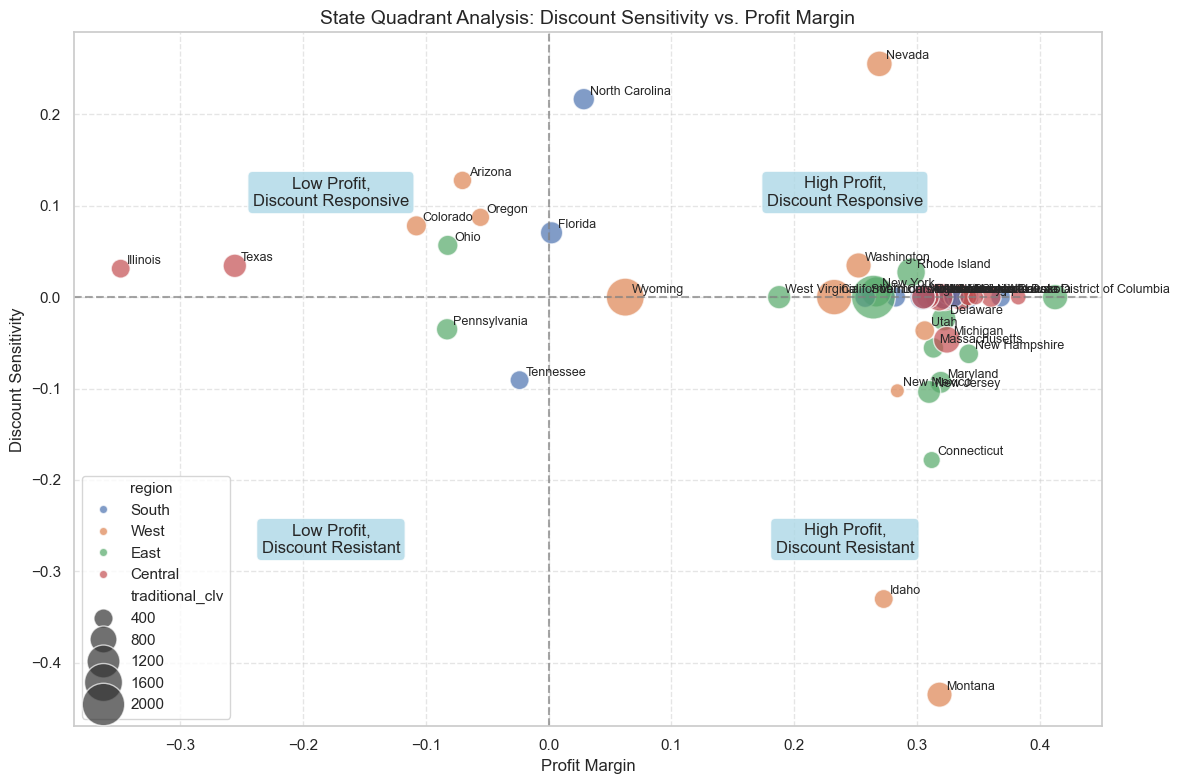

In [ ]:
# 4. State Quadrant Analysis
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='profit_margin',
    y='discount_sensitivity',
    size='traditional_clv',
    hue='region',
    sizes=(100, 1000),
    alpha=0.7,
    data=state_metrics
)

# Add quadrant lines
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.7)
plt.axvline(x=0, color='gray', linestyle='--', alpha=0.7)

# Add labels for each state
for i, row in state_metrics.iterrows():
    plt.text(row['profit_margin'] + 0.005, 
             row['discount_sensitivity'] + 0.005, 
             row['state'], 
             fontsize=9)

# Add quadrant labels
plt.annotate('High Profit,\nDiscount Responsive', xy=(0.75, 0.75), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Responsive', xy=(0.25, 0.75), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('High Profit,\nDiscount Resistant', xy=(0.75, 0.25), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)
plt.annotate('Low Profit,\nDiscount Resistant', xy=(0.25, 0.25), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.3", fc='lightblue', alpha=0.8), ha='center', fontsize=12)

plt.title('State Quadrant Analysis: Discount Sensitivity vs. Profit Margin', fontsize=14)
plt.xlabel('Profit Margin', fontsize=12)
plt.ylabel('Discount Sensitivity', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()  # This displays the plot directly in VS Code



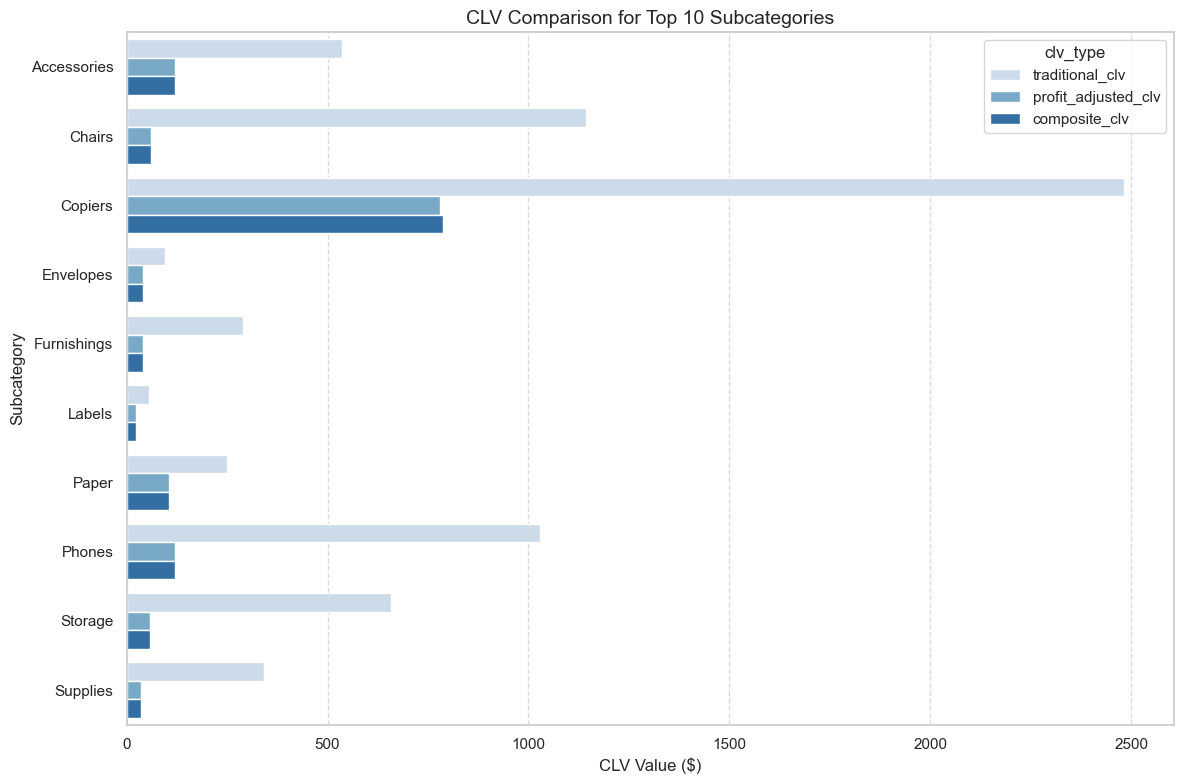

In [ ]:
  # 5. CLV Comparison across Subcategories
  plt.figure(figsize=(12, 8))
  subcategory_clv_melted = pd.melt(
      subcategory_metrics,
      id_vars=['sub-category', 'category'],
      value_vars=['traditional_clv', 'profit_adjusted_clv', 'composite_clv'],
      var_name='clv_type',
      value_name='value'
  )
  
  # Take top 10 subcategories only
  top_subcats = subcategory_metrics.sort_values('composite_clv', ascending=False)['sub-category'].head(10).tolist()
  top_subcat_data = subcategory_clv_melted[subcategory_clv_melted['sub-category'].isin(top_subcats)]
  
  sns.barplot(
      x='value',
      y='sub-category',
      hue='clv_type',
      data=top_subcat_data,
      palette='Blues'
  )
  plt.title('CLV Comparison for Top 10 Subcategories', fontsize=14)
  plt.xlabel('CLV Value ($)', fontsize=12)
  plt.ylabel('Subcategory', fontsize=12)
  plt.grid(True, linestyle='--', alpha=0.7, axis='x')
  plt.tight_layout()
  plt.show()  # This displays the plot directly in VS Code
